# A4
## Part 1 - Extracting the main lobe of the spectrum of a window

In [11]:
import os
import sys
import numpy as np

from scipy.signal import get_window
from scipy.fftpack import fft, fftshift

import math
import matplotlib.pyplot as plt
% matplotlib inline
eps = np.finfo(float).eps

sys.path.append('../../software/models/')
import stft
import utilFunctions as UF

import loadTestCases

Write a function that extracts the main lobe of the magnitude spectrum of a window given a window type and its length (`M`). The function should return the samples corresponding to the main lobe in decibels (dB).

To compute the spectrum, take the FFT size (`N`) to be 8 times the window length (`N = 8*M`) (For this part, `N` need not be a power of 2). 

The input arguments to the function are the window type (window) and the length of the window (`M`). 
The function should return a numpy array containing the samples corresponding to the main lobe of 
the window. 

In the returned numpy array you should include the samples corresponding to both the local minimas
across the main lobe. 

The possible window types that you can expect as input are rectangular (`'boxcar'`), `'hamming'` or
`'blackmanharris'`.

NOTE: You can approach this question in two ways: 

1) You can write code to find the indices of the local minimas across the main lobe. 

2) You can manually note down the indices of these local minimas by plotting and a visual inspection of the spectrum of the window. If done manually, the indices have to be obtained for each possible window types separately (as they differ across different window types).

Tip: log10(0) is not well defined, so its a common practice to add a small value such as `eps = 1e-16` 
to the magnitude spectrum before computing it in dB. This is optional and will not affect your answers. 
If you find it difficult to concatenate the two halves of the main lobe, you can first center the 
spectrum using `fftshift()` and then compute the indexes of the minimas around the main lobe.

In [12]:
def extractMainLobe(window, M):
    """
    Input:
            window (string): Window type to be used (Either rectangular ('boxcar'), 'hamming' or '
                blackmanharris')
            M (integer): length of the window to be used
    Output:
            The function should return a numpy array containing the main lobe of the magnitude 
            spectrum of the window in decibels (dB).
    """

    w = get_window(window, M)         # get the window 
    
    ### Your code here
    N = 8*M
    
    # zero padding and zero phase windowing
    fftbuffer = np.zeros(N)
    hM1 = (M+1)//2
    hM2 = M//2
    
    fftbuffer[:hM1] = w[-hM1:]
    fftbuffer[-hM2:] = w[:hM2]
    
    # fft
    X = fft(fftbuffer)
    #X = fftshift(X)           # shift the zero-phase compomnet
    
    absX = np.abs(X)
    absX[ absX < np.finfo(float).eps ] = 10e-16
    
    mX = 20*np.log10(absX)
    
    # find the minimas aound the main lobe
    # 1. find the first minimas from left to right
    first_minimas_index = 0
    for i in range(N-1):
        current_val = mX[i]
        next_val = mX[i+1]
        
        if next_val > current_val:
            first_minimas_index = i
            break;
    
    # 2. find the second minimas from right to right
    second_minimas_index = 0
    for i in range(N-1, -1, -1):
        current_val = mX[i]
        next_val = mX[i-1]
        
        if next_val > current_val:
            second_minimas_index = i
            break;
    
    # return the main lobe samples
    main_lobe_samples = np.concatenate([mX[second_minimas_index:], mX[:first_minimas_index+1]])
    
    return main_lobe_samples

Test case 1: If you run your code using `window = 'blackmanharris'` and `M = 100`, the output numpy 
array should contain 65 samples.

Test case 2: If you run your code using `window = 'boxcar'` and `M = 120`, the output numpy array 
should contain 17 samples.

Test case 3: If you run your code using `window = 'hamming'` and `M = 256`, the output numpy array 
should contain 33 samples.

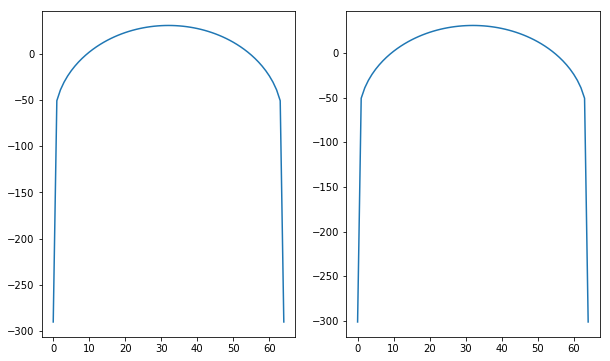

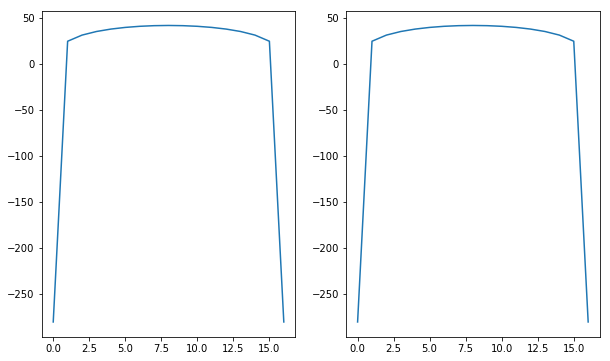

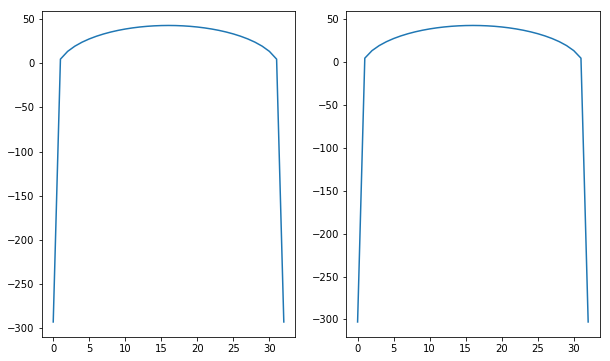

In [13]:
## Your code here
# test
for i in range(1, 4):
    test_data = loadTestCases.load(1, i)
    input_data = test_data['input']
    output_data = test_data['output']
    
    main_lobe_samples = extractMainLobe(input_data['window'], input_data['M'])
    
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.plot(output_data)
    
    plt.subplot(1,2,2)
    plt.plot(main_lobe_samples)
        
    assert(main_lobe_samples.size == output_data.size)

## Part 2 - Measuring noise in the reconstructed signal using the STFT model 

Write a function that measures the amount of noise introduced during the analysis and synthesis of a 
signal using the STFT model. Use SNR (signal to noise ratio) in dB to quantify the amount of noise. 
Use the `stft()` function in `stft.py` to do an analysis followed by a synthesis of the input signal.

A brief description of the SNR computation can be found in the pdf document (`A4-STFT.pdf`, in Relevant 
Concepts section) in the assignment directory (A4). Use the time domain energy definition to compute
the SNR.

With the input signal and the obtained output, compute two different SNR values for the following cases:

1) `SNR1`: Over the entire length of the input and the output signals.

2) `SNR2`: For the segment of the signals left after discarding `M` samples from both the start and the end, where `M` is the analysis window length. Note that this computation is done after STFT analysis and synthesis.

The input arguments to the function are the wav file name including the path (`inputFile`), window 
type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a python 
tuple of both the SNR values in decibels: `(SNR1, SNR2)`. Both SNR1 and SNR2 are float values. 

In [14]:
def computeEnergy(x):
    return np.sum(np.square(x))

def computeSNR_(signal, noise):
    assert(signal.size == noise.size)
    
    signal_e = computeEnergy(signal)
    noise_e = computeEnergy(noise)
    
    return 10*np.log10(signal_e/noise_e)

def computeSNR(inputFile, window, M, N, H):
    """
    Input:
            inputFile (string): wav file name including the path 
            window (string): analysis window type (choice of rectangular, triangular, hanning, hamming, 
                    blackman, blackmanharris)
            M (integer): analysis window length (odd positive integer)
            N (integer): fft size (power of two, > M)
            H (integer): hop size for the stft computation
    Output:
            The function should return a python tuple of both the SNR values (SNR1, SNR2)
            SNR1 and SNR2 are floats.
    """
    ## your code here
    fs, x = UF.wavread(inputFile)
    
    # stft analysis and synthesis
    w = get_window(window, M)
    y = stft.stft(x, w, N, H)
    
    # the difference between output y and input x
    noise = (x - y)
    
    # calculating the snr1
    snr_1 = computeSNR_(x, noise)
    
    # calculating the snr2
    seg_x = x[M:-M]
    seg_noise = noise[M:-M]
    snr_2 = computeSNR_(seg_x, seg_noise)
    
    return snr_1, snr_2

Test case 1: If you run your code using `piano.wav` file with `'blackman'` window, `M = 513`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(67.57748352378475, 304.68394693221649)`.

Test case 2: If you run your code using `sax-phrase-short.wav` file with `'hamming'` window, `M = 512`, 
`N = 1024` and `H = 64`, the output SNR values should be around: `(89.510506656299285, 306.18696700251388)`.

Test case 3: If you run your code using `rain.wav` file with `'hann'` window, `M = 1024`, `N = 2048` and 
`H = 128`, the output SNR values should be around: `(74.631476225366825, 304.26918192997738)`.

Due to precision differences on different machines/hardware, compared to the expected SNR values, your 
output values can differ by +/-10dB for `SNR1` and +/-100dB for `SNR2`.

In [15]:
## Your code here
# test
for i in range(1, 4):
    test_data = loadTestCases.load(2, i)
    input_data = test_data['input']
    output_data = test_data['output']
    
    snr_1, snr_2 = computeSNR(input_data['inputFile'], input_data['window'],\
                              input_data['M'], input_data['N'], input_data['H'])
    print(snr_1, snr_2, output_data)

67.540185986 86.3571616925 (67.57662100899816, 304.68310458266501)
89.5105066563 306.162151677 (89.510350011846782, 306.18681035804565)
74.5453826607 92.9049664681 (74.631040119778049, 304.26876366098691)


## Part 3 - Computing band-wise energy envelopes of a signal

Write a function that computes band-wise energy envelopes of a given audio signal by using the STFT.
Consider two frequency bands for this question, low and high. The low frequency band is the set of 
all the frequencies between 0 and 3000 Hz and the high frequency band is the set of all the 
frequencies between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). 
At a given frame, the value of the energy envelope of a band can be computed as the sum of squared 
values of all the frequency coefficients in that band. Compute the energy envelopes in decibels. 

Refer to `A4-STFT.pdf` document for further details on computing bandwise energy.

The input arguments to the function are the wav file name including the path (`inputFile`), window 
type (`window`), window length (`M`), FFT size (`N`) and hop size (`H`). The function should return a numpy 
array with two columns, where the first column is the energy envelope of the low frequency band and 
the second column is that of the high frequency band.

Use `stft.stftAnal()` to obtain the STFT magnitude spectrum for all the audio frames. Then compute two 
energy values for each frequency band specified. While calculating frequency bins for each frequency 
band, consider only the bins that are within the specified frequency range. For example, for the low 
frequency band consider only the bins with frequency > 0 Hz and < 3000 Hz (you can use `np.where()` to 
find those bin indexes). This way we also remove the DC offset in the signal in energy envelope 
computation. The frequency corresponding to the bin index `k` can be computed as `k*fs/N`, where `fs` is 
the sampling rate of the signal.

To get a better understanding of the energy envelope and its characteristics you can plot the envelopes 
together with the spectrogram of the signal. You can use `matplotlib` plotting library for this purpose. 
To visualize the spectrogram of a signal, a good option is to use colormesh. You can reuse the code in
`sms-tools/lectures/4-STFT/plots-code/spectrogram.py`. Either overlay the envelopes on the spectrogram 
or plot them in a different subplot. Make sure you use the same range of the x-axis for both the 
spectrogram and the energy envelopes.

NOTE: Running these test cases might take a few seconds depending on your hardware.


In [16]:
def computeEngEnv(inputFile, window, M, N, H):
    """
    Inputs:
            inputFile (string): input sound file (monophonic with sampling rate of 44100)
            window (string): analysis window type (choice of rectangular, triangular, hanning, 
                hamming, blackman, blackmanharris)
            M (integer): analysis window size (odd positive integer)
            N (integer): FFT size (power of 2, such that N > M)
            H (integer): hop size for the stft computation
    Output:
            The function should return a numpy array engEnv with shape Kx2, K = Number of frames
            containing energy envelop of the signal in decibles (dB) scale
            engEnv[:,0]: Energy envelope in band 0 < f < 3000 Hz (in dB)
            engEnv[:,1]: Energy envelope in band 3000 < f < 10000 Hz (in dB)
    """
    
    ### your code here
    
    # read file, get fs and signal
    fs, x = UF.wavread(inputFile)
    
    # get window
    w = get_window(window, M)
    
    # stft
    mX,_ = stft.stftAnal(x, w, N, H)
    
    # convert to linear scale
    mX = 10**(mX/20)
        
    num_frame = mX.shape[0]       
    engEnv = np.zeros((num_frame, 2))
    
    fre_in_each_bin = fs/N
    
    
    k0_low = 1
    k1_low = int(3000//fre_in_each_bin)
    
    
    k0_high = k1_low + 1
    k1_high = int(10000//fre_in_each_bin)
    
    for i in range(num_frame):
        # energy envelope in (0, 3000) 
        engEnv[i, 0] = np.sum(np.square(mX[i, k0_low:k1_low]))
        
        # energy envelope in (3000, 10000)
        engEnv[i, 1] = np.sum(np.square(mX[i, k0_high:k1_high]))
    
    # convert to db
    engEnv = 10 * np.log10(engEnv)
    return engEnv

Test case 1: Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples). To numerically compare your output, use `loadTestCases.py`
script to obtain the expected output.

Test case 2: Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples). To numerically compare your output, use `loadTestCases.py` script to obtain the expected output.

Test case 3: Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples). To numerically compare your output, use 
`loadTestCases.py` script to obtain the expected output.

In addition to comparing results with the expected output, you can also plot your output for these 
test cases.You can clearly notice the sharp attacks and decay of the piano notes for test case 1 
(See figure in the accompanying pdf). You can compare this with the output from test case 2 that 
uses a larger window. You can infer the influence of window size on sharpness of the note attacks 
and discuss it on the forums.

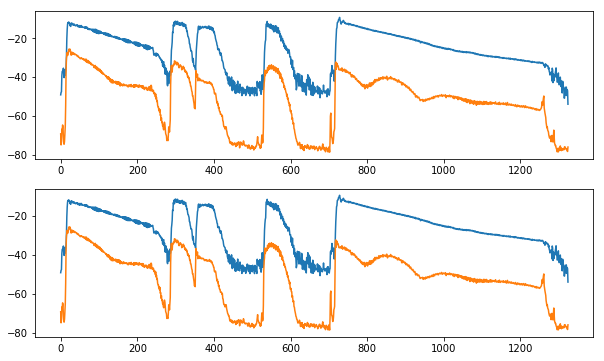

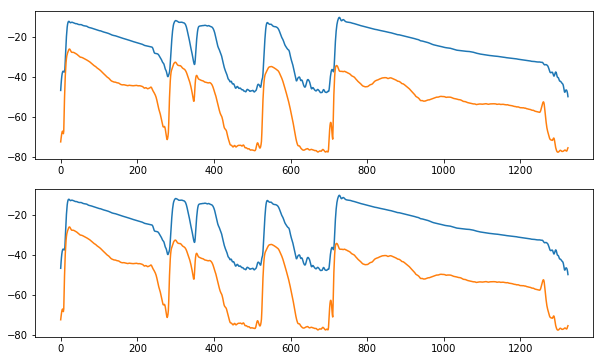

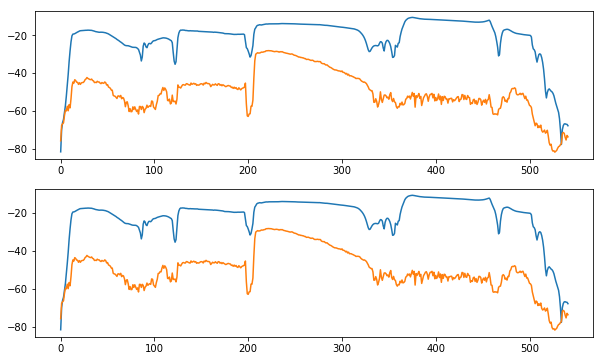

In [17]:
## Your code here
## Your code here
# test
for i in range(1, 4):
    test_data = loadTestCases.load(3, i)
    input_data = test_data['input']
    output_data = test_data['output']
    
    eng_env = computeEngEnv(input_data['inputFile'], input_data['window'],
                            input_data['M'],input_data['N'],input_data['H'])
    
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(output_data[:,0])
    plt.plot(output_data[:,1])
    
    plt.subplot(2,1,2)
    plt.plot(eng_env[:,0])
    plt.plot(eng_env[:,1])

In [20]:
def computeEngEnv(inputFile, window, M, N, H):
    """
    Inputs:
            inputFile (string): input sound file (monophonic with sampling rate of 44100)
            window (string): analysis window type (choice of rectangular, triangular, hanning, 
                hamming, blackman, blackmanharris)
            M (integer): analysis window size (odd positive integer)
            N (integer): FFT size (power of 2, such that N > M)
            H (integer): hop size for the stft computation
    Output:
            The function should return a numpy array engEnv with shape Kx2, K = Number of frames
            containing energy envelop of the signal in decibles (dB) scale
            engEnv[:,0]: Energy envelope in band 0 < f < 3000 Hz (in dB)
            engEnv[:,1]: Energy envelope in band 3000 < f < 10000 Hz (in dB)
    """
    def energy(mY):
        eDB = 10 * np.log10(np.sum((10 ** (mY / 20)) ** 2, axis = 1))
        return eDB
    
    (fs, x) = UF.wavread(inputFile)
    low_bound = int(np.ceil(float(3000) * N / fs))
    high_bound = int(np.ceil(float(10000) * N / fs))
    w = get_window(window, M)

    mX, pX = stft.stftAnal(x, w, N, H)
    low_band = np.transpose(np.transpose(mX)[1:low_bound])
    high_band = np.transpose(np.transpose(mX)[low_bound:high_bound])

    eDB_low = energy(low_band)
    eDB_high = energy(high_band)

    engEnv = np.append([eDB_low], [eDB_high], axis = 0)
    engEnv = np.transpose(engEnv)

    return engEnv

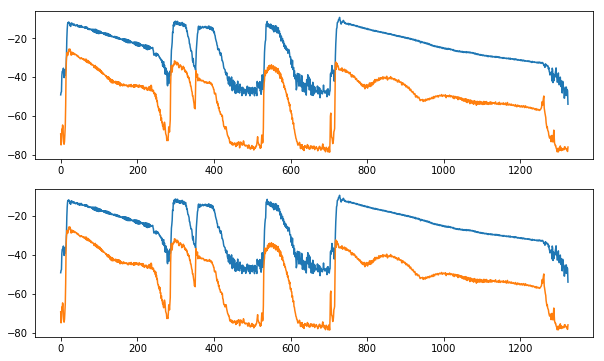

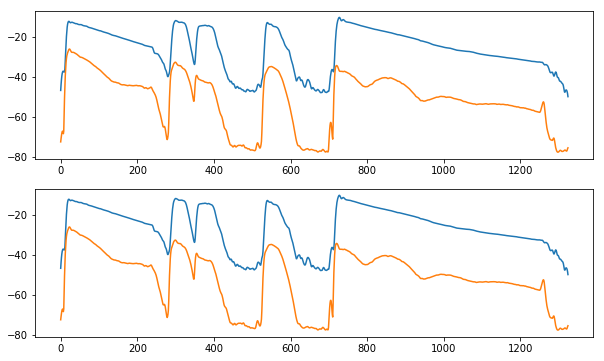

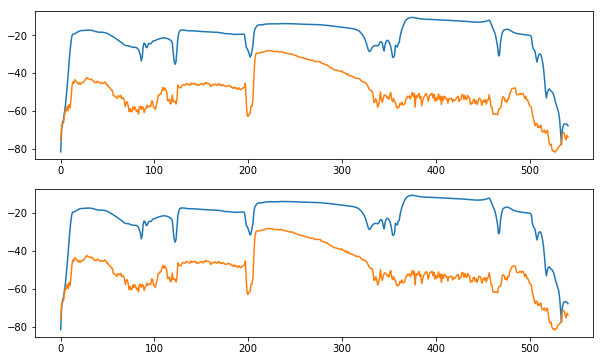

In [21]:
# test
for i in range(1, 4):
    test_data = loadTestCases.load(3, i)
    input_data = test_data['input']
    output_data = test_data['output']
    
    eng_env = computeEngEnv(input_data['inputFile'], input_data['window'],
                            input_data['M'],input_data['N'],input_data['H'])
    
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(output_data[:,0])
    plt.plot(output_data[:,1])
    
    plt.subplot(2,1,2)
    plt.plot(eng_env[:,0])
    plt.plot(eng_env[:,1])

## Part 4 - Computing onset detection function (Optional)

Write a function to compute a simple onset detection function (ODF) using the STFT. Compute two ODFs 
one for each of the frequency bands, low and high. The low frequency band is the set of all the 
frequencies between 0 and 3000 Hz and the high frequency band is the set of all the frequencies 
between 3000 and 10000 Hz (excluding the boundary frequencies in both the cases). 

A brief description of the onset detection function can be found in the pdf document (`A4-STFT.pdf`, 
in Relevant Concepts section) in the assignment directory (`A4`). Start with an initial condition of 
`ODF(0) = 0` in order to make the length of the ODF same as that of the energy envelope. Remember to 
apply a half wave rectification on the ODF. 

The input arguments to the function are the wav file name including the path (`inputFile`), window 
type (`window`), window length (`M`), FFT size (`N`), and hop size (`H`). The function should return a numpy 
array with two columns, where the first column is the ODF computed on the low frequency band and the 
second column is the ODF computed on the high frequency band.

Use `stft.stftAnal()` to obtain the STFT magnitude spectrum for all the audio frames. Then compute two 
energy values for each frequency band specified. While calculating frequency bins for each frequency 
band, consider only the bins that are within the specified frequency range. For example, for the low 
frequency band consider only the bins with frequency > 0 Hz and < 3000 Hz (you can use `np.where()` to 
find those bin indexes). This way we also remove the DC offset in the signal in energy envelope 
computation. The frequency corresponding to the bin index `k` can be computed as `k*fs/N`, where `fs` is 
the sampling rate of the signal.

To get a better understanding of the energy envelope and its characteristics you can plot the envelopes 
together with the spectrogram of the signal. You can use matplotlib plotting library for this purpose. 
To visualize the spectrogram of a signal, a good option is to use colormesh. You can reuse the code in
`sms-tools/lectures/4-STFT/plots-code/spectrogram.py`. Either overlay the envelopes on the spectrogram 
or plot them in a different subplot. Make sure you use the same range of the x-axis for both the 
spectrogram and the energy envelopes.

NOTE: Running these test cases might take a few seconds depending on your hardware.

In [9]:
def computeEngEnv(inputFile, window, M, N, H):
    """
    Inputs:
            inputFile (string): input sound file (monophonic with sampling rate of 44100)
            window (string): analysis window type (choice of rectangular, triangular, hanning, 
                hamming, blackman, blackmanharris)
            M (integer): analysis window size (odd positive integer)
            N (integer): FFT size (power of 2, such that N > M)
            H (integer): hop size for the stft computation
    Output:
            The function should return a numpy array engEnv with shape Kx2, K = Number of frames
            containing energy envelop of the signal in decibles (dB) scale
            engEnv[:,0]: Energy envelope in band 0 < f < 3000 Hz (in dB)
            engEnv[:,1]: Energy envelope in band 3000 < f < 10000 Hz (in dB)
    """
    
    ### your code here
    
    # read file, get fs and signal
    fs, x = UF.wavread(inputFile)
    
    # get window
    w = get_window(window, M)
    
    # stft
    mX,_ = stft.stftAnal(x, w, N, H)
    
    # convert to linear scale
    mX = 10**(mX/20)
        
    num_frame = mX.shape[0]       
    engEnv = np.zeros((num_frame, 2))
    
    fre_in_each_bin = fs/N
    
    
    k0_low = 1
    k1_low = int(3000//fre_in_each_bin)
    
    
    k0_high = k1_low + 1
    k1_high = int(10000//fre_in_each_bin)
    
    for i in range(num_frame):
        # energy envelope in (0, 3000) 
        engEnv[i, 0] = np.sum(np.square(mX[i, k0_low:k1_low]))
        
        # energy envelope in (3000, 10000)
        engEnv[i, 1] = np.sum(np.square(mX[i, k0_high:k1_high]))
    
    # convert to db
    engEnv = 10 * np.log10(engEnv)
    return engEnv

def computeODF(inputFile, window, M, N, H):
    """
    Inputs:
            inputFile (string): input sound file (monophonic with sampling rate of 44100)
            window (string): analysis window type (choice of rectangular, triangular, hanning, hamming, 
                blackman, blackmanharris)
            M (integer): analysis window size (odd integer value)
            N (integer): fft size (power of two, bigger or equal than than M)
            H (integer): hop size for the STFT computation
    Output:
            The function should return a numpy array with two columns, where the first column is the ODF 
            computed on the low frequency band and the second column is the ODF computed on the high 
            frequency band.
            ODF[:,0]: ODF computed in band 0 < f < 3000 Hz 
            ODF[:,1]: ODF computed in band 3000 < f < 10000 Hz
    """
    
    ### your code here
    
    engEnv = computeEngEnv(inputFile, window, M, N, H)
    ODF = np.zeros_like(engEnv)
    
    num_frame = engEnv.shape[0]
    
    for i in range(1, num_frame):
        # calculate ODF in band (0, 3000)
        ODF[i, 0] = engEnv[i, 0] - engEnv[i-1, 0]
        # calculate ODF in band (3000,10000)
        ODF[i, 1] = engEnv[i, 1] - engEnv[i-1, 1]
        
    # half wave rectification
    ODF[ ODF <= np.finfo(float).eps ] = 0.0
    
    return ODF

Test case 1: Use `piano.wav` file with `window = 'blackman'`, `M = 513`, `N = 1024` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 69 (69 samples) and of the high frequency 
band span from 70 to 232 (163 samples). To numerically compare your output, use `loadTestCases.py`
script to obtain the expected output.

Test case 2: Use `piano.wav` file with `window = 'blackman'`, `M = 2047`, `N = 4096` and `H = 128` as input. 
The bin indexes of the low frequency band span from 1 to 278 (278 samples) and of the high frequency 
band span from 279 to 928 (650 samples). To numerically compare your output, use `loadTestCases.py`
script to obtain the expected output.

Test case 3: Use `sax-phrase-short.wav` file with `window = 'hamming'`, `M = 513`, `N = 2048` and `H = 256` as 
input. The bin indexes of the low frequency band span from 1 to 139 (139 samples) and of the high 
frequency band span from 140 to 464 (325 samples). To numerically compare your output, use 
`loadTestCases.py` script to obtain the expected output.

In addition to comparing results with the expected output, you can also plot your output for these 
test cases. For test case 1, you can clearly see that the ODFs have sharp peaks at the onset of the 
piano notes (See figure in the accompanying pdf). You will notice exactly 6 peaks that are above 
10 dB value in the ODF computed on the high frequency band. 

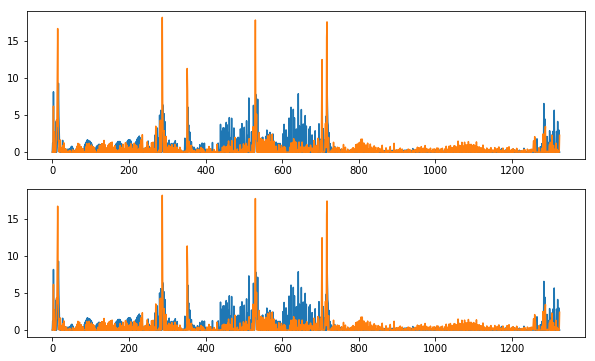

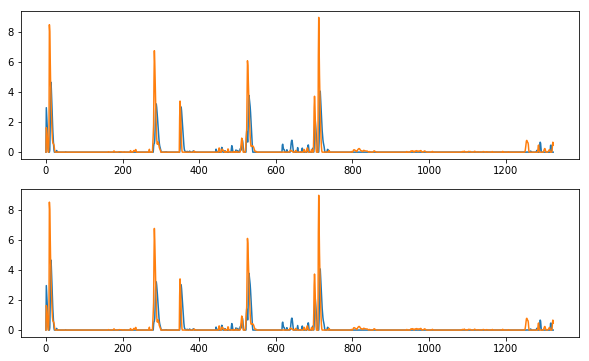

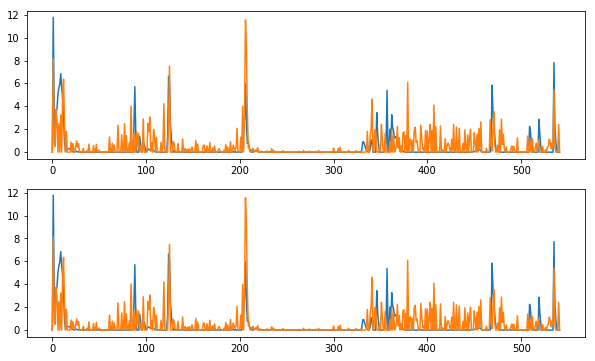

In [78]:
## Your code here
# test
for i in range(1, 4):
    test_data = loadTestCases.load(4, i)
    input_data = test_data['input']
    output_data = test_data['output']
    
    eng_env = computeODF(input_data['inputFile'], input_data['window'],
                            input_data['M'],input_data['N'],input_data['H'])
    
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(output_data[:,0])
    plt.plot(output_data[:,1])
    
    plt.subplot(2,1,2)
    plt.plot(eng_env[:,0])
    plt.plot(eng_env[:,1])